## Links:

Introductory video:
https://www.youtube.com/watch?v=IPQmGzYuxmc

Introductory documentation:
https://pytorch.org/docs/stable/quantization.html

In PyTorch 1.3 where code was run it is said to be an EXPERIMENTAL feature.

Links below were helpful in understanding the details
* https://pytorch.org/tutorials/advanced/static_quantization_tutorial.html
* https://pytorch.org/docs/master/quantization.html#quantized-torch-tensor-operations
* https://github.com/pytorch/pytorch/blob/master/torch/quantization/quantize.py

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import torch
import torch.quantization as quantization
import torch.nn as nn
import torch.nn.quantized as qnn

from mnist import MNIST
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook as tqdm

In [34]:
torch.__version__

'1.3.0.post2'

# Prepare dataset

In [35]:
class MnistDataset(Dataset):
    def __init__(self, mnist_data_path, use_test=False):
        self.mndata = MNIST(mnist_data_path)
        if use_test:
            self.images, self.labels = self.mndata.load_testing()
        else:
            self.images, self.labels = self.mndata.load_training()
        
        self.images = np.array(self.images).reshape(-1, 1, 28, 28)/255
        self.labels = np.array(self.labels)
        
    def __len__(self):
         return self.images.shape[0]

    def __getitem__(self, index):
        return torch.tensor(self.images[index], dtype=torch.float), int(self.labels[index])

In [36]:
data = MnistDataset('../torch_quant/python-mnist/data/')
data_test = MnistDataset('../torch_quant/python-mnist/data/', use_test=True)

# Prepare model

In [37]:
class MyModel(nn.Module):
    def __init__(self, qconfig, num_classes=10):
        super(MyModel, self).__init__()
        self.qconfig = qconfig
        self.conv1 = nn.Conv2d( 1,  8, kernel_size=3, stride=2, padding=2, bias=True)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        
        self.conv2 = nn.Conv2d( 8, 16, kernel_size=2, stride=1, padding=2, bias=True)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
            
        self.conv3 = nn.Conv2d(16, 32, kernel_size=2, stride=1, padding=2, bias=True)
        self.relu3 = nn.ReLU(inplace=True)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout2d = nn.Dropout2d(p=0.1)
        self.dropout = nn.Dropout(p=0.3)
        self.fc = nn.Linear(32, num_classes)
        
    def forward(self, x):
        x = self.maxpool1(self.relu1(self.conv1(x)))
        x = self.dropout2d(x)
        x = self.maxpool2(self.relu2(self.conv2(x)))
        x = self.dropout2d(x)
        x = self.maxpool3(self.relu3(self.conv3(x)))
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

model = MyModel(quantization.get_default_qat_qconfig())
model.load_state_dict(torch.load('orig.pth'))
model.qconfig = quantization.get_default_qat_qconfig()

In [39]:
# prepare model for quantization-aware training
pmodel = quantization.fuse_modules(model, [['conv1','relu1'],['conv2','relu2'],['conv3','relu3']])
qmodel = torch.quantization.prepare_qat(pmodel, inplace=True)
model = qmodel

# Train model (dummy, not caring about super results here)

In [41]:
optimizer = SGD(model.parameters(), lr=0.001, momentum=0, dampening=0, weight_decay=0, nesterov=False)
criterion = CrossEntropyLoss()
scheduler = StepLR(optimizer, 10, 0.1)
epochs = 5
batch_size = 16

dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(data_test, batch_size=batch_size, shuffle=False)

train_acc = []
test_acc = []

best = 0

if os.path.isfile('qa_best.pth'):
    model.load_state_dict(torch.load('qa_best.pth'))
else:
    for e in range(epochs):
        model.train()
        losses = []
        tloader = tqdm(dataloader, leave=False)
        number = 0
        hits = 0

        for img, label in tloader:
            optimizer.zero_grad()  
            output = model(img)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            losses.append(float(loss))
            number += output.shape[0]
            output = output.detach().numpy()
            label = label.detach().numpy()
            hits += np.sum( np.argmax(output, axis=1) == label )
            tloader.desc = f"E{e+1}/{epochs} {np.mean(losses):0.5f} ACC: {(hits/number):0.5f}" 
        
        model.eval()
        tloader = tqdm(dataloader, leave=False)
        losses = []
        number = 0
        hits = 0
        with torch.no_grad():
            for img, label in tloader:
                output = model(img)
                loss = criterion(output, label)

                losses.append(float(loss))
                number += output.shape[0]
                output = output.detach().numpy()
                label = label.detach().numpy()
                hits += np.sum( np.argmax(output, axis=1) == label )
                
                tloader.desc = f"E{e+1}/{epochs} {np.mean(losses):0.5f} ACC: {(hits/number):0.5f}"
        print(f"[E{e+1}]: Train Acc: {(hits/number):0.5f}")
        train_acc.append(hits/number)
        
        tloader = tqdm(dataloader_test, leave=False)
        losses = []
        number = 0
        hits = 0
        with torch.no_grad():
            for img, label in tloader:
                output = model(img)
                loss = criterion(output, label)

                losses.append(float(loss))
                number += output.shape[0]
                output = output.detach().numpy()
                label = label.detach().numpy()
                hits += np.sum( np.argmax(output, axis=1) == label )
                
                tloader.desc = f"E{e+1}/{epochs} {np.mean(losses):0.5f} ACC: {(hits/number):0.5f}"
        print(f"[E{e+1}]: Test Acc: {(hits/number):0.5f}")  
        test_acc.append(hits/number)
        
        if best<hits/number:
            best = hits/number
            torch.save(model.state_dict(),"qa_best.pth")
                
        
    scheduler.step()

[E1]: Train Acc: 0.96613


[E1]: Test Acc: 0.96760


[E2]: Train Acc: 0.96667


[E2]: Test Acc: 0.96800


[E3]: Train Acc: 0.96662


[E3]: Test Acc: 0.96790


[E4]: Train Acc: 0.96655


[E4]: Test Acc: 0.96750


[E5]: Train Acc: 0.96677


[E5]: Test Acc: 0.96800


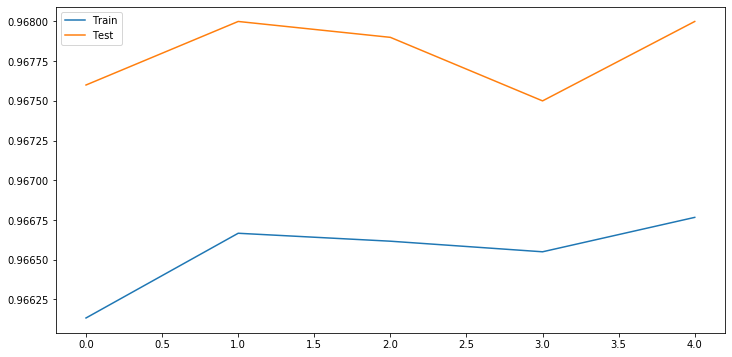

In [42]:
plt.figure(figsize=(12,6))
plt.plot(train_acc, label='Train')
plt.plot(test_acc, label='Test')
plt.legend()
pass

In [43]:
test_acc[-1]

0.968

# Quantization

In [44]:
dummy = torch.zeros(1,1,28,28, dtype=torch.float)
test_iterations = 10000

In [45]:
model.load_state_dict(torch.load('qa_best.pth'))

<All keys matched successfully>

In [49]:
model.eval()

time_start = time.time()
for i in range(test_iterations):
    result = model.forward(dummy)
time_stop = time.time()
q_time = int(1000*(time_stop-time_start))

print(f"Result shape: {result.shape} Test time: {q_time}ms",)
print(f"QA_Model file size: {os.path.getsize('qa_best.pth')}")

Result shape: torch.Size([1, 10]) Test time: 65413ms
QA_Model file size: 20206


In [50]:
model.load_state_dict(torch.load('qa_best.pth'))
model.eval()
# Check acc
tloader = tqdm(dataloader_test)
number = 0
hits = 0
for img, label in tloader: 
    output = model(img)
    number += output.shape[0]
    output = output.detach().numpy()
    label = label.detach().numpy()
    hits += np.sum( np.argmax(output, axis=1) == label )
print(f"Accuracy: {(hits/number):0.5f}")


Accuracy: 0.96810


### perform quantization

In [53]:
model.load_state_dict(torch.load('qa_best.pth'))
model.eval()

## Convert model
final_model = quantization.convert(qmodel)


# first layer scale
print(final_model.conv1)
print(final_model.fc)

QuantizedConvReLU2d(1, 8, kernel_size=(3, 3), stride=(2, 2), scale=0.04059883579611778, zero_point=0, padding=(2, 2))
QuantizedLinear(in_features=32, out_features=10, scale=0.23584559559822083, zero_point=58)


### test time & size after quantization

In [54]:
qmodel.eval()
qdummy = torch.quantize_per_tensor(dummy, scale=1, zero_point=0, dtype=torch.quint8) 

time_start = time.time()
for i in range(test_iterations):
    result = final_model.forward(qdummy)
time_stop = time.time()
q_time = int(1000*(time_stop-time_start))

print(f"Result shape: {result.shape} Test time: {q_time}ms",)

# Check acc
tloader = tqdm(dataloader_test)
number = 0
hits = 0
for img, label in tloader: 
    img = torch.quantize_per_tensor(img, scale=1, zero_point=0, dtype=torch.quint8) 
    output = final_model(img)
    number += output.shape[0]
    output = torch.dequantize(output).detach().numpy()
    label = label.detach().numpy()
    hits += np.sum( np.argmax(output, axis=1) == label )
print(f"Accuracy: {(hits/number):0.5f}")

torch.save(final_model.state_dict(),"qa_q.pth")
print(f"QA_QModel file size: {os.path.getsize('qa_q.pth')}")

Result shape: torch.Size([1, 10]) Test time: 2693ms



Accuracy: 0.95560
QA_QModel file size: 6527
